In [1]:
source("../../functions.R")

seurat = readRDS('Data/tissue_seurat.RDS')
setwd('Figures/Figure 1')

Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.5.3"Loading required package: cowplot
Warning message:
"package 'cowplot' was built under R version 3.5.3"
********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: Matrix
Warning message:
"package 'feather' was built under R version 3.5.3"Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: viridisLite
Warning message:
"package 'tidyr' was built under R version 3.5.3"
Attaching package: 'tidyr'

The following object

In [2]:
# set up palettes
phenotype_palette =ggthemes_data[['tableau']][['color-palettes']]$regular$`Tableau 10`$value
names(phenotype_palette) =  levels(factor(seurat@meta.data$phenotype))


In [3]:
# a small number of cells from esophageal biopsies are classified as duodenual epithelial cells, and vice versa
# these cells are excluded from further analysis
seurat@meta.data$pheno_plot = seurat@meta.data$phenotype
seurat@meta.data$pheno_plot[seurat@meta.data$tissue == 'Esophagus' & seurat@meta.data$phenotype == 'Duodenum epithelium'] = NA
seurat@meta.data$pheno_plot[seurat@meta.data$tissue == 'Duodenum' & seurat@meta.data$phenotype == 'Esophagus epithelium'] = NA

seurat@meta.data$patient = factor(seurat@meta.data$patient, levels = c(292, 354, 451, 471, 474, 475, 249, 355, 392, 468))
seurat@meta.data$tissue = factor(seurat@meta.data$tissue, levels = c('Esophagus', 'Duodenum'))

plot_data = seurat@meta.data
plot_data = plot_data[sample(rownames(plot_data), length(rownames(plot_data))),]
plot_data = plot_data %>% filter(!is.na(pheno_plot))

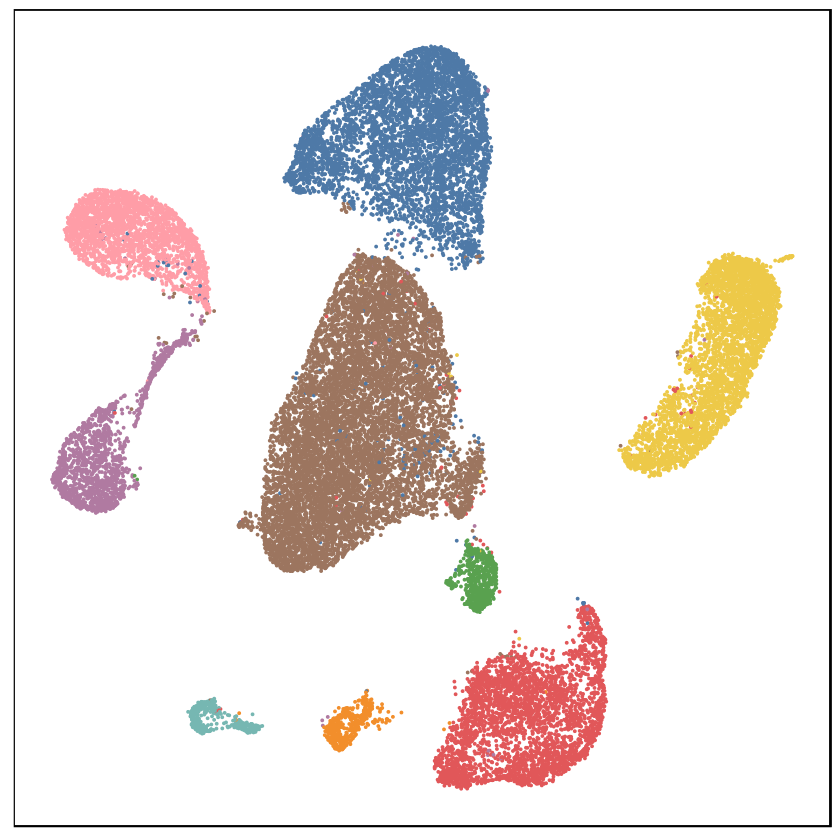

In [4]:
# Figure 1B: UMAP by phenotype
seurat = addUMAP(seurat)

ggplot(plot_data, aes(x = UMAP1, y = UMAP2, color = as.character(phenotype))) + geom_point(size= .02) + UMAP_theme + scale_color_manual(values = phenotype_palette) +
scale_x_continuous(limits =c (-12.2, 13)) + scale_y_continuous(limits = c(-13.32, 12.15))

ggsave('phenotype_umap.tiff', height = 2, width =2, dpi = 1000)

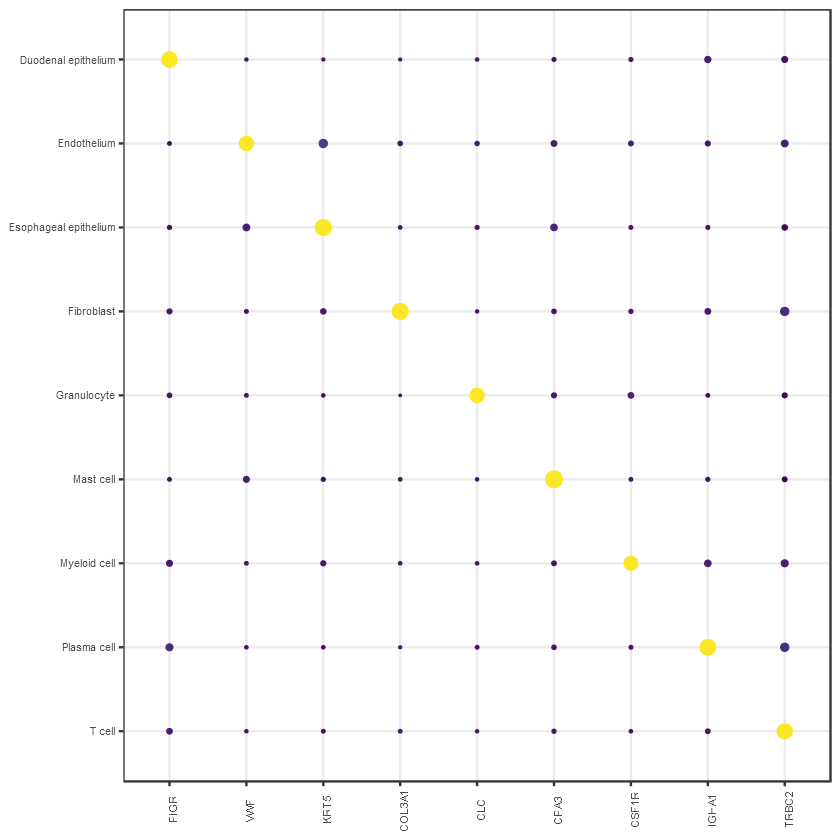

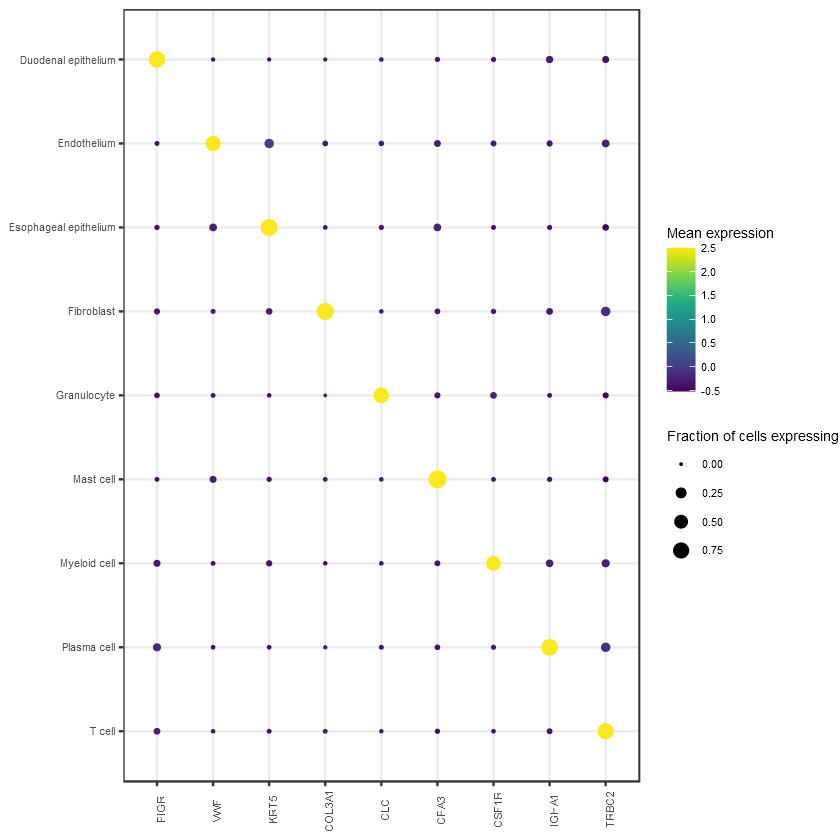

In [5]:
# Figure 1C: expression of marker genes intissue-resident cell populations
genes = c("PIGR", 'VWF','KRT5', 'COL3A1', 'CLC','CPA3', 'CSF1R', 'IGHA1', 'TRBC2')

data = as.data.frame(t(as.matrix(seurat@data[genes,])))
data$phenotype = seurat@meta.data$phenotype
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp)) %>% as.data.frame() 
df_exp[,2:(1+length(genes))] = scale(df_exp[,2:(1+length(genes))])
df_exp = df_exp %>% melt(id.vars = 'phenotype')
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value[df_exp$value > 2.5] = 2.5
df_exp$value[df_exp$value < -1.5]= -1.5
df_exp$pct = df_pct$value


lvs = levels(factor(df_exp$phenotype))
ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle = 90)) + 
labs(color = "Mean expression", size = 'Fraction of cells expressing') + scale_x_discrete(limits = genes) + Axis_themes + 
theme(axis.title = element_blank(), axis.text = element_text(size = 6)) + scale_y_discrete(limits = rev(lvs)) + guides(size = FALSE, color = FALSE)+ scale_size_continuous(range = c(.01, 4), breaks = c(0,.25, .5, .75))
ggsave('marker_genes.pdf', height = 2.3, width = 2.6, useDingbats = FALSE)

ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle = 90)) + 
labs(color = "Mean expression", size = 'Fraction of cells expressing') + scale_x_discrete(limits = genes) + Axis_themes + 
theme(axis.title = element_blank(), axis.text = element_text(size = 6)) + scale_y_discrete(limits = rev(lvs)) + scale_size_continuous(range = c(.01, 4), breaks = c(0,.25, .5, .75, 1))
ggsave('marker_genes_legend.pdf', height = 3, width = 2.6, useDingbats = FALSE)


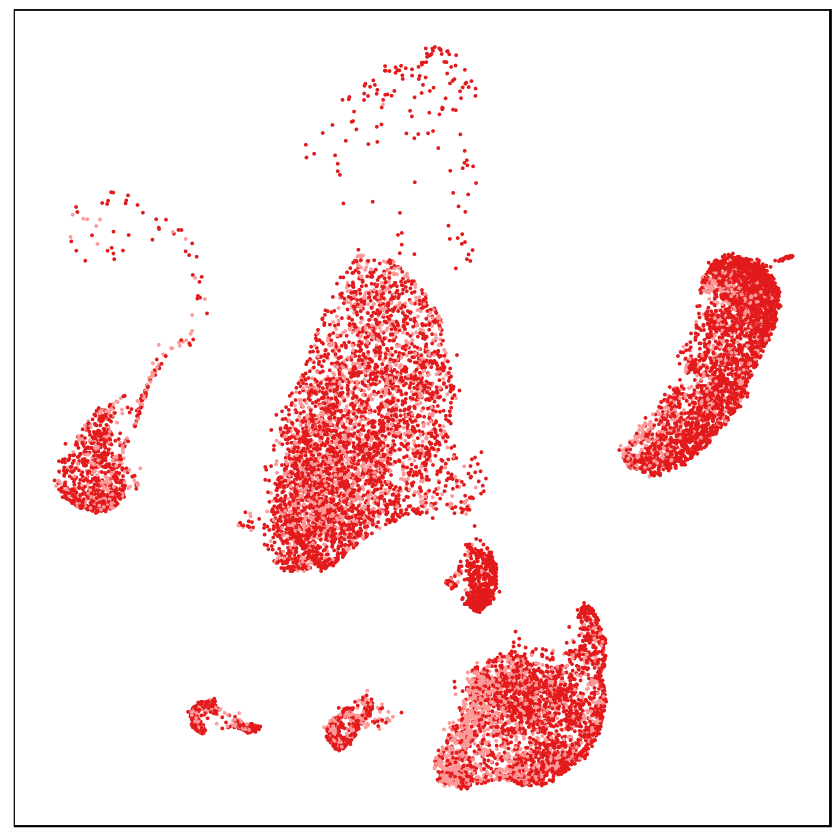

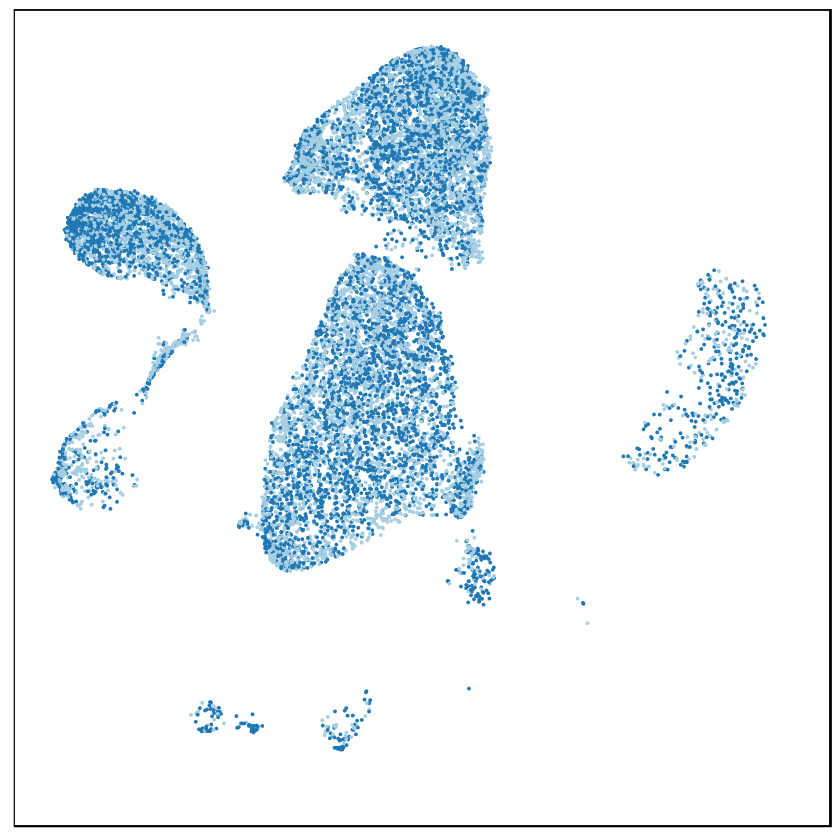

In [6]:
# UMAP plots of esophagus only and duodenum only

ggplot(plot_data %>% filter(tissue == 'Esophagus'), aes(x = UMAP1, y = UMAP2, color = ci)) + geom_point(size = .01) + UMAP_theme + scale_color_manual(values = tissue_palette) + 
scale_x_continuous(limits =c (-12.2, 13)) + scale_y_continuous(limits = c(-13.32, 12.15))

ggsave('esophagus_umap.tiff', height =2, width = 2, dpi = 1000)

ggplot(plot_data %>% filter(tissue == 'Duodenum'), aes(x = UMAP1, y = UMAP2, color = ci)) + geom_point(size = .01) + UMAP_theme + scale_color_manual(values = tissue_palette) + 
scale_x_continuous(limits =c (-12.2, 13)) + scale_y_continuous(limits = c(-13.32, 12.15))

ggsave('duodenum_umap.tiff', height = 2, width = 2, dpi = 1000)

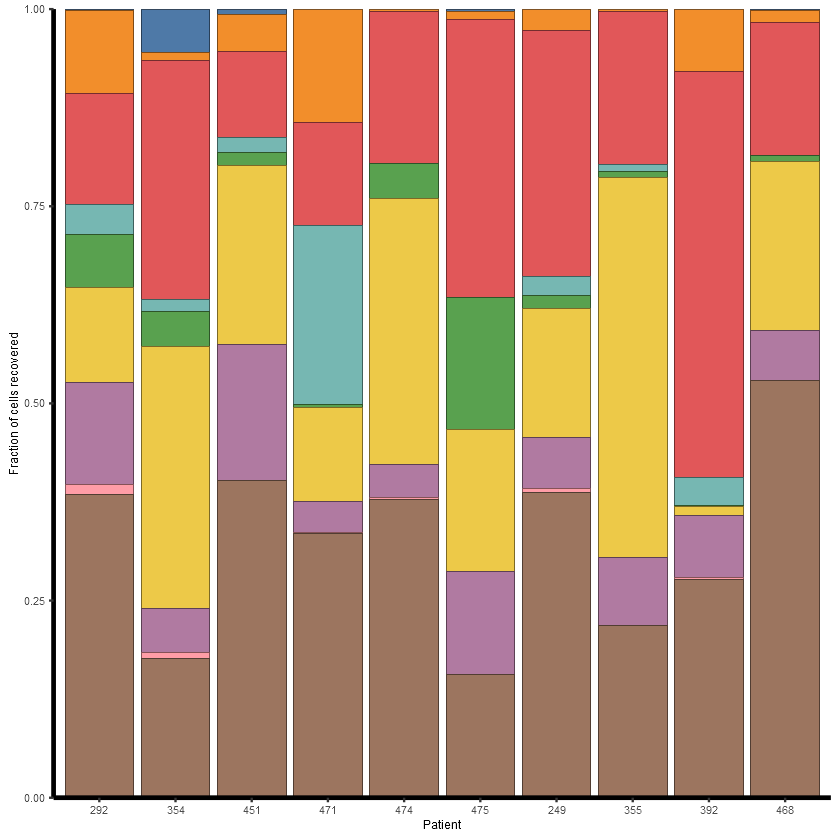

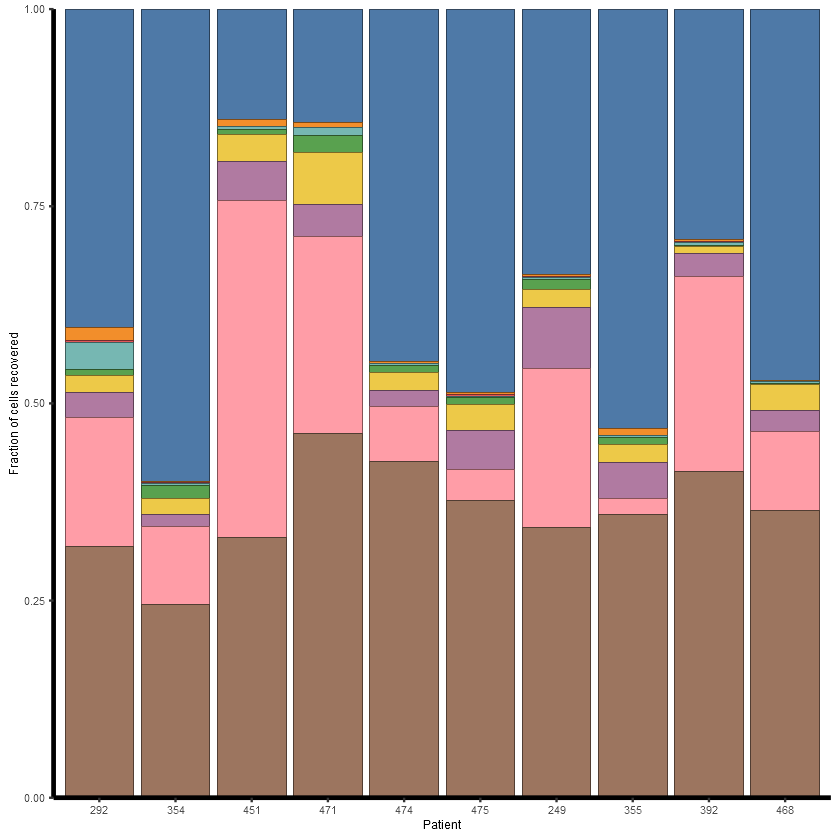

In [7]:
# Figure 1E: frequency of cells from esopahgeal and duodenalbiopsies

ggplot(plot_data %>% filter(tissue == 'Esophagus'), aes(x = factor(patient), fill = phenotype)) + geom_bar(position = 'fill', size = .1, color = 'black') + 
Axis_themes + remove_grid+  
labs(x = 'Patient', y = 'Fraction of cells recovered', fill = 'Phenotype') + theme(axis.line = element_line(color = 'black', size = 1), plot.background = element_blank(), 
                                                                                               panel.spacing.x = unit(0, 'null'), strip.background = element_blank(), 
                                                                                               panel.border = element_blank()) + Axis_themes +

scale_y_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0))) + 
scale_fill_manual(values = phenotype_palette) + guides(fill = FALSE)
ggsave('esophageal_frequencies.pdf', width = 3, height = 2.5, useDingbats = FALSE)


ggplot(plot_data %>% filter(tissue == 'Duodenum'), aes(x = factor(patient), fill = pheno_plot)) + geom_bar(position = 'fill', size = .1, color = 'black') + Axis_themes + remove_grid+  
scale_fill_manual(values = phenotype_palette) +
labs(x = 'Patient', y = 'Fraction of cells recovered', fill = 'Phenotype') + theme(axis.line = element_line(color = 'black', size = 1), plot.background = element_blank(), 
                                                                                               panel.spacing.x = unit(0, 'null'), strip.background = element_blank(), 
                                                                                               panel.border = element_blank()) + Axis_themes +
scale_y_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0))) + guides(fill = FALSE)
ggsave('duodenal_frequencies.pdf', width = 3, height = 2.5, useDingbats = FALSE)

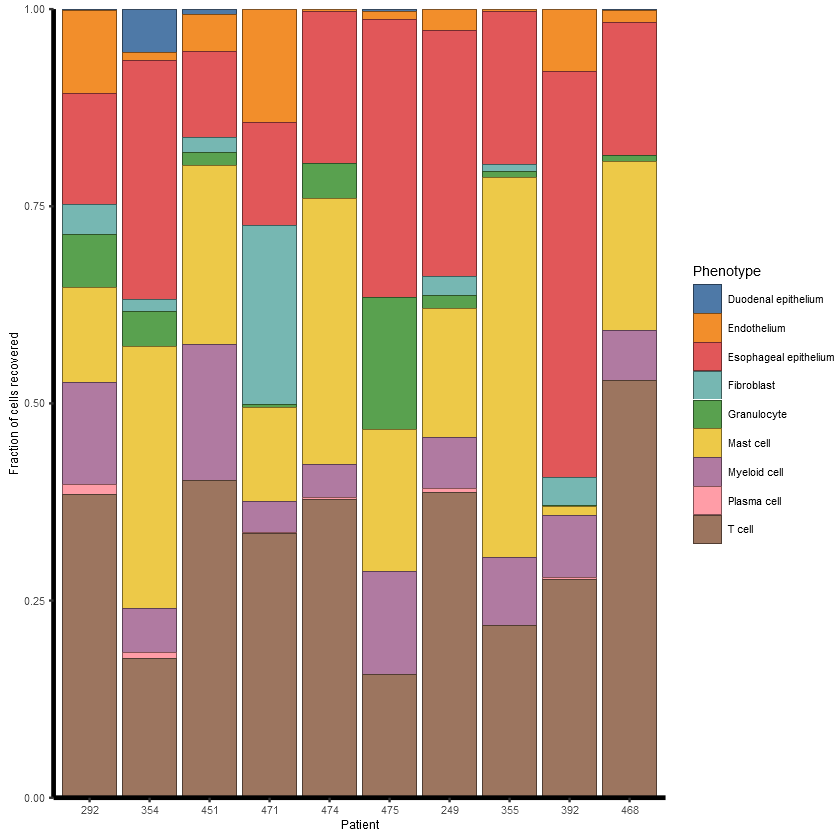

In [8]:
ggplot(plot_data %>% filter(tissue == 'Esophagus'), aes(x = factor(patient), fill = phenotype)) + geom_bar(position = 'fill', size = .1, color = 'black') + 
Axis_themes + remove_grid+  
#facet_grid(tissue~diagnosis, scales = 'free', space ='free')+ 
labs(x = 'Patient', y = 'Fraction of cells recovered', fill = 'Phenotype') + theme(axis.line = element_line(color = 'black', size = 1), plot.background = element_blank(), 
                                                                                               panel.spacing.x = unit(0, 'null'), strip.background = element_blank(), 
                                                                                               panel.border = element_blank()) + Axis_themes +

scale_y_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0))) + 
scale_fill_manual(values = phenotype_palette) 

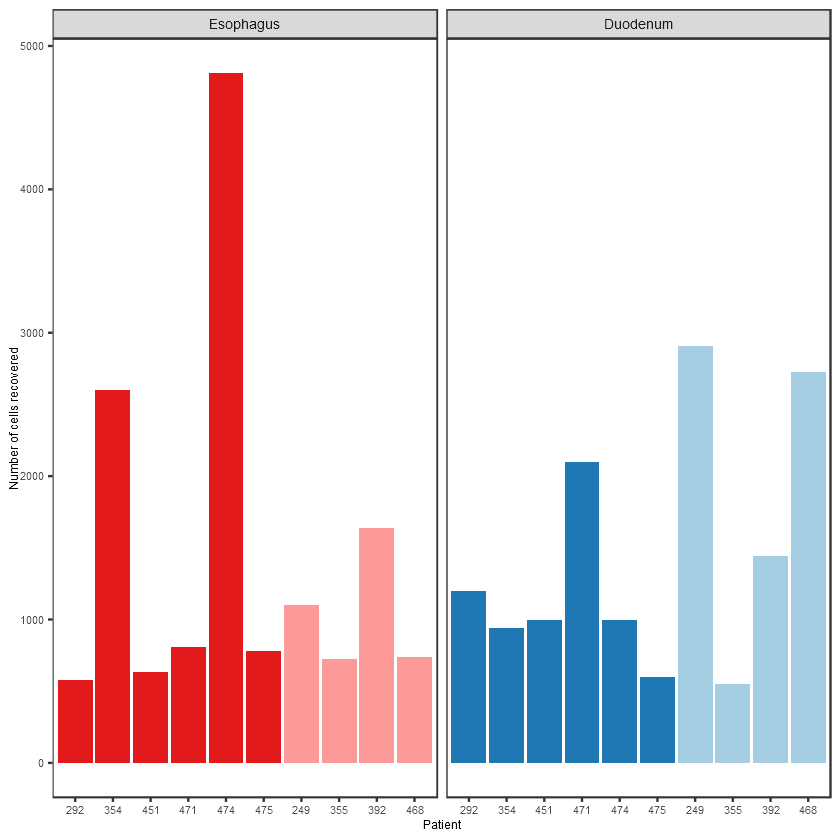

In [9]:
# supplementary figure 1a: number of cells passing thresholds by patient/tissue
ggplot(seurat@meta.data, aes(x = factor(patient), fill = ci)) + facet_wrap(~tissue) + geom_bar()+ scale_fill_manual(values = tissue_palette) + remove_grid +Axis_themes + 
labs(x = 'Patient', y = 'Number of cells recovered') + guides(fill = FALSE)

ggsave('cellnum.pdf', width = 6, height = 2.5, useDingbats = FALSE)

df = seurat@meta.data %>% group_by(patient, tissue) %>% summarize(n = n())
write.csv(df, 's1.csv')

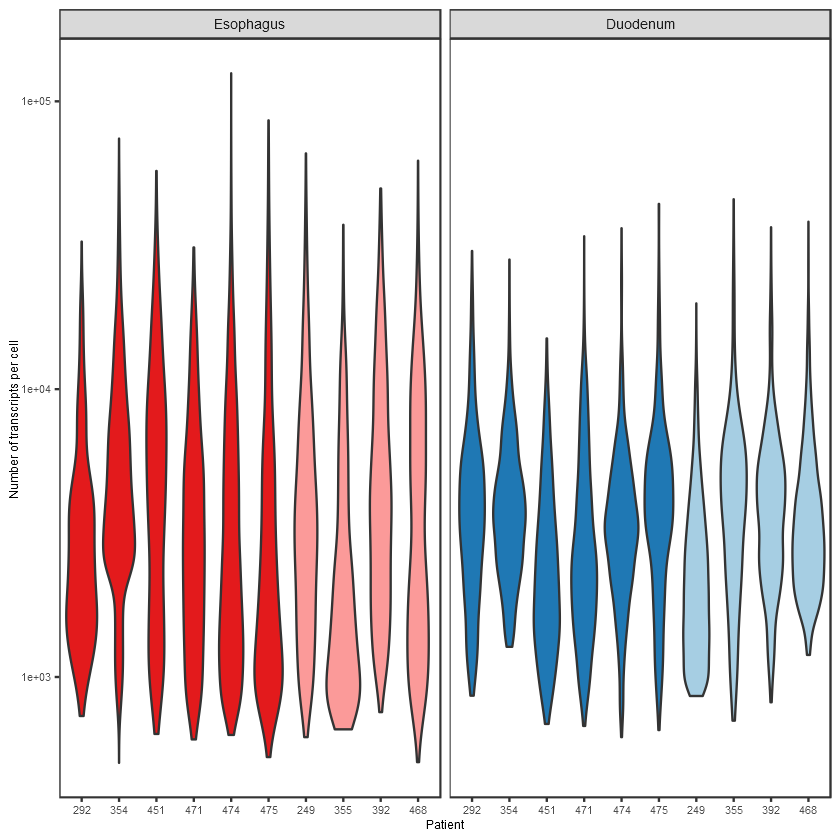

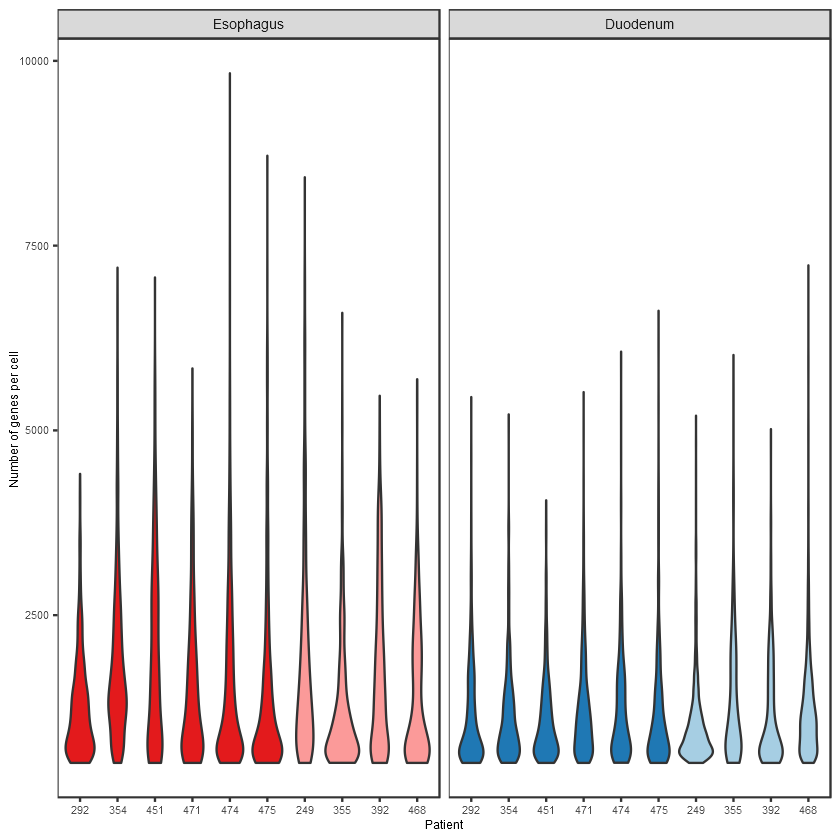

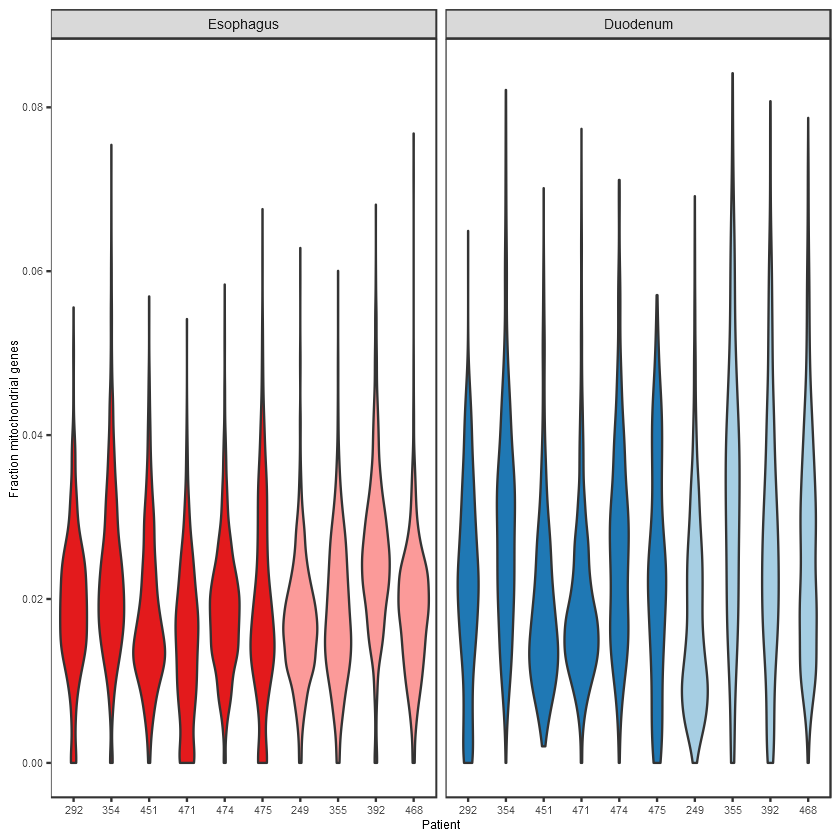

In [10]:
# supplemntary figure 1b: QC metrics
ggplot(seurat@meta.data, aes(x = factor(patient), y = nUMI, fill = ci)) + facet_wrap(~tissue) + geom_violin() + scale_y_log10() + scale_fill_manual(values = tissue_palette) + remove_grid +Axis_themes + 
labs(x = 'Patient', y = 'Number of transcripts per cell') + guides(fill = FALSE)
ggsave('nUMI.pdf', width = 6, height = 2, useDingbats = FALSE)

ggplot(seurat@meta.data, aes(x = factor(patient), y = nGene, fill = ci)) + facet_wrap(~tissue) + geom_violin() + scale_fill_manual(values = tissue_palette) + remove_grid +Axis_themes + 
labs(x = 'Patient', y = 'Number of genes per cell') + guides(fill = FALSE)
ggsave('nGene.pdf', width = 6, height = 2, useDingbats = FALSE)

ggplot(seurat@meta.data, aes(x = factor(patient), y = percent.mito, fill = ci)) + facet_wrap(~tissue) + geom_violin()+ scale_fill_manual(values = tissue_palette) + remove_grid +Axis_themes + 
labs(x = 'Patient', y = 'Fraction mitochondrial genes') + guides(fill = FALSE)
ggsave('mito.pdf', width = 6, height = 2, useDingbats = FALSE)

In [11]:
# determine differentially expressed genes for each cluster
seurat = SetAllIdent(seurat, 'phenotype')
#markers.all = FindAllMarkers(seurat, test.use = 'wilcox', logfc.threshold = .5)
markers.all = readRDS('markers.all.RDS')

In [12]:
options(repr.plot.height = 10)
set.seed(1)

# pick top 10 differentially genes by p-value for each cluster
sub = markers.all %>% group_by(cluster) %>% arrange(cluster, desc(p_val), avg_logFC) %>% filter(avg_logFC > 0, pct.1 > .2)  %>% top_n(10, wt =desc(p_val)) %>% top_n(10, wt = avg_logFC)
genes.use = sub$gene
seurat@meta.data$cellname = rownames(seurat@meta.data)

# obtain gene expression data for a random subset of cells
cells.use = seurat@meta.data %>% group_by(phenotype) %>% sample_n(100)
phenos = cells.use$phenotype
cells.use = cells.use$cellname

data = seurat@data[genes.use, cells.use]

# scale data and plot heatmap
data = t(scale(t(data)))
data[data > 2] = 2
data[data < -1] = -1
coldata = data.frame(row.names = colnames(data), Phenotype = phenos)
pheatmap(data, cluster_rows = FALSE, cluster_cols = FALSE, show_colnames = FALSE, color = viridis(100), annotation_col = coldata, border_color = NA,
        annotation_colors = list(Phenotype = phenotype_palette), fontsize = 6, filename = 'cluster_heatmap.pdf')

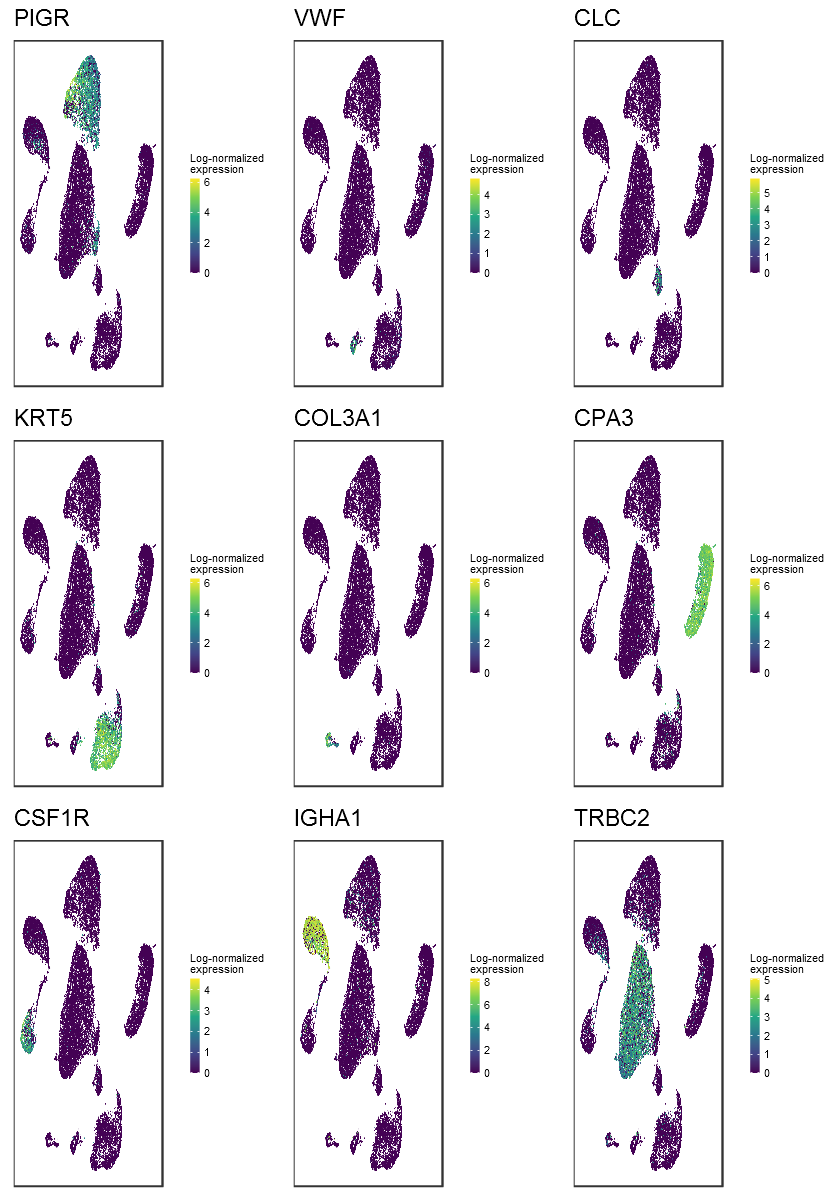

In [13]:
geneplot = function (seurat, genes) 
{
    plots = c()
    for (curr in genes) {
        seurat@meta.data$gene = seurat@data[curr, rownames(seurat@meta.data)]
        plots[[curr]] = ggplot(shuffle(seurat@meta.data), aes(x = UMAP1, 
            y = UMAP2, color = gene)) + ggrastr::geom_point_rast(size = 0.04) + 
            scale_color_viridis_c() + labs(title = curr) + 
            theme(axis.title = element_blank(), axis.text = element_blank()) + 
            remove_grid + labs(x = c(),  y =c(), color = 'Log-normalized\nexpression') + theme(axis.text.x = element_blank(), 
                                                        axis.text.y = element_blank(), 
                                                        axis.ticks = element_blank(), 
                                                        legend.text = element_text(size = 6), 
                                                        legend.title = element_text(size = 6), 
                                                        legend.key.height= unit(.4, 'cm'),
                                                        legend.key.width= unit(.2, 'cm'))
    }
    gg = plot_grid(plotlist = plots)
    gg
}

geneplot(seurat, c('PIGR', 'VWF', 'CLC', 'KRT5', 'COL3A1', 'CPA3', 'CSF1R', 'IGHA1', 'TRBC2'))
ggsave('featureplots.pdf', useDingbats = FALSE, height = 5, width = 6)

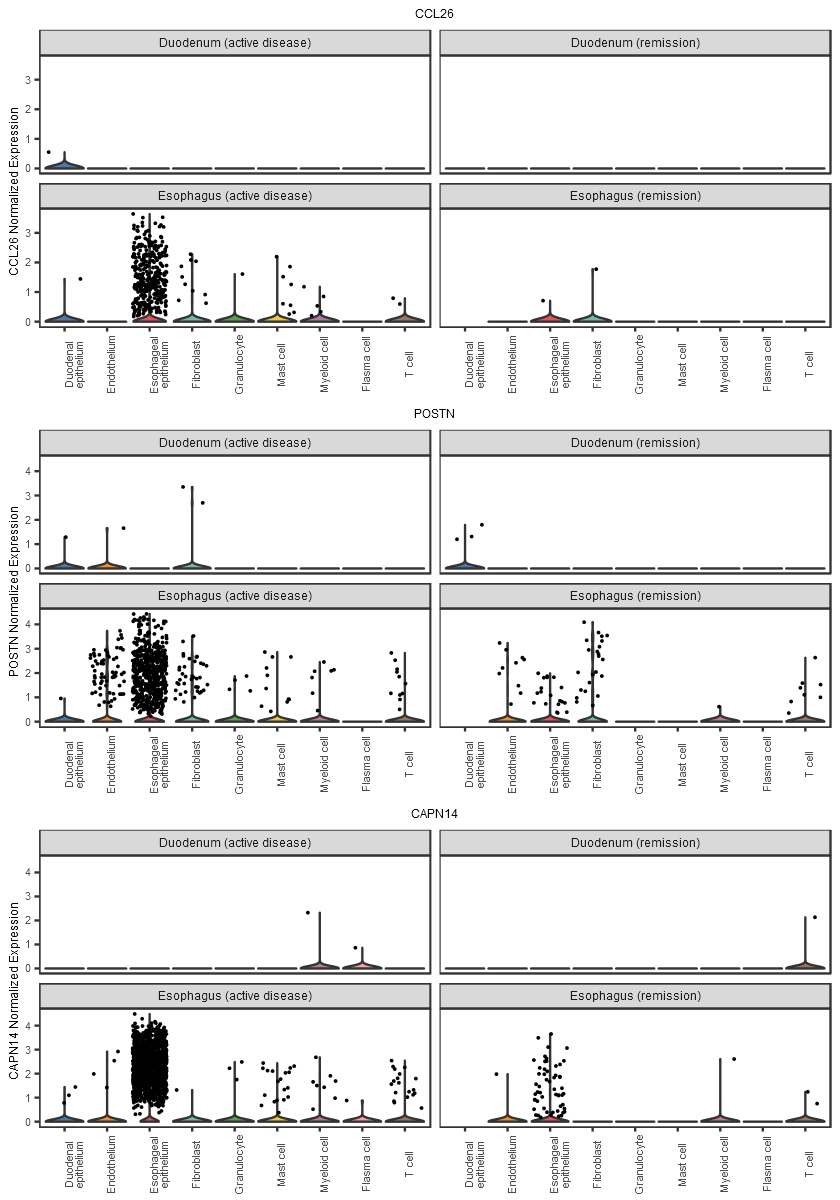

In [14]:
genes = c( 'CCL26', 'POSTN', 'CAPN14')
data = as.data.frame(t(as.matrix(seurat@data[genes,])))

data$phenotype = seurat@meta.data$ci
data$phenotype = as.character(data$phenotype)
data$phenotype[data$phenotype == 'Diseased_D'] = 'Duodenum (active disease)'

data$phenotype[data$phenotype == 'Diseased_E'] = 'Esophagus (active disease)'
data$phenotype[data$phenotype == 'Remission_D'] = 'Duodenum (remission)'
data$phenotype[data$phenotype == 'Remission_E'] = 'Esophagus (remission)'

data$celltype = seurat@meta.data$phenotype

data$celltype = as.character(data$celltype)
data$celltype[data$celltype  == 'Esophageal epithelium'] = 'Esophageal\nepithelium'
data$celltype[data$celltype  == 'Duodenal epithelium'] = 'Duodenal\nepithelium'


g1 = ggplot(data, aes(x = celltype, y = CCL26, fill = celltype)) + geom_violin(bw = .1) + geom_jitter(data = data %>% filter(CCL26 > 0), size = .01) + facet_wrap('phenotype', nrow = 2) + theme_bw() + remove_grid +  
Axis_themes + theme(axis.text.x = element_text(angle = 90), strip.text.x = element_text(size = 7)) + scale_fill_manual(values = phenotype_palette) + labs(x = c(), y = 'CCL26 Normalized Expression') + guides(fill = FALSE) + ggtitle('CCL26') + 
theme(plot.title = element_text(size=7, hjust = 0.5))
#ggsave('ccl26.pdf', height = 2.7, width = 6, useDingbats = FALSE)

g2 = ggplot(data, aes(x = celltype, y = POSTN, fill = celltype)) + geom_violin(bw = .1) + geom_jitter(data = data %>% filter(POSTN > 0), size = .01) + facet_wrap('phenotype', nrow = 2) + theme_bw() + remove_grid +  
Axis_themes + theme(axis.text.x = element_text(angle = 90), strip.text.x = element_text(size = 7)) +scale_fill_manual(values = phenotype_palette) + labs(x = c(), y = 'POSTN Normalized Expression') + guides(fill = FALSE) + ggtitle('POSTN') + 
theme(plot.title = element_text(size=7, hjust = 0.5))
#ggsave('postn.pdf', height = 2.7, width = 6, useDingbats = FALSE)

g3 = ggplot(data, aes(x = celltype, y = CAPN14, fill = celltype)) + geom_violin(bw = .1) + geom_jitter(data = data %>% filter(CAPN14 > 0), size = .01) + facet_wrap('phenotype', nrow = 2) + theme_bw() + remove_grid +  
Axis_themes + theme(axis.text.x = element_text(angle = 90), strip.text.x = element_text(size = 7)) + scale_fill_manual(values = phenotype_palette) + labs(x = c(), y = 'CAPN14 Normalized Expression') + guides(fill = FALSE) + ggtitle("CAPN14") + 
theme(plot.title = element_text(size=7, hjust = 0.5))
#ggsave('capn14.pdf', height = 2.7, width = 6, useDingbats = FALSE)

plot_grid(g1, g2, g3, ncol = 1)
ggsave('violins.pdf', height = 8, width = 6, useDingbats = FALSE)